In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM.MinimalModelSemisymbolic

using Base.Threads
using JLD2
using DataFrames, FreqTables, AlgebraOfGraphics, NamedArrays, StatsBase

In [2]:
using GLMakie
using CairoMakie
CairoMakie.activate!()
GLMakie.activate!(; px_per_unit=2.)
# display(GLMakie.Screen(), f.figure)
ENV["COLUMNS"] = 280

280

# Loading pscan data

In [3]:
data = jldopen("../cluster_env/runs/mmsa_pscan6/out_fdf.jld2");
params_mlKcd = [data[x] for x in ["m", "l", "K", "c", "d"]];
params_Ds = [data[x] for x in ["DN", "DG", "DR"]];
# df = data["df"];
df = load_object("../cluster_env/runs/mmsa_pscan6/out_finite.jld2");

In [4]:
function get_random_row(df)
    df[rand(1:nrow(df)),:]
end
function df_row_to_mmp(dfrow)
    MinimalModelParamsSpace(
        dfrow.m, dfrow.l, dfrow.K, dfrow.c, dfrow.d,
        dfrow.DN, dfrow.DG, dfrow.DR
    )
end

df_row_to_mmp (generic function with 1 method)

# Basics and plots

In [305]:
@show nrow(df)
describe(df)

nrow(df) = 4211302


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,0.444242,0.0078125,0.15875,4.0,0,Float64
2,l,0.580213,0.111111,0.555556,1.0,0,Float64
3,K,1.0,1.0,1.0,1.0,0,Float64
4,c,3.71598,0.00949939,1.86275,16.0,0,Float64
5,d,1.90498,0.0078125,0.320628,16.0,0,Float64
6,DN,9.46669e-5,1.0e-7,1.0e-7,0.1,0,Float64
7,DG,1.0,1.0,1.0,1.0,0,Float64
8,DR,13.3685,1.0e-7,5.87802e-5,100000.0,0,Float64
9,numss,1.0,1,1.0,1,0,Int64


## Checks

### Multiple steady states?

In [39]:
mssdf = df[df.numss .!= 1,:];
nrow(mssdf)

0

### Multiple modes? Should not be unless a param is 0

In [40]:
mmdf = df[df.nummodes .!= 1,:];
@show nrow(mmdf)
unique(mmdf.DN)

nrow(mmdf) = 0


Float64[]

## Exploratory plots

### Correlations

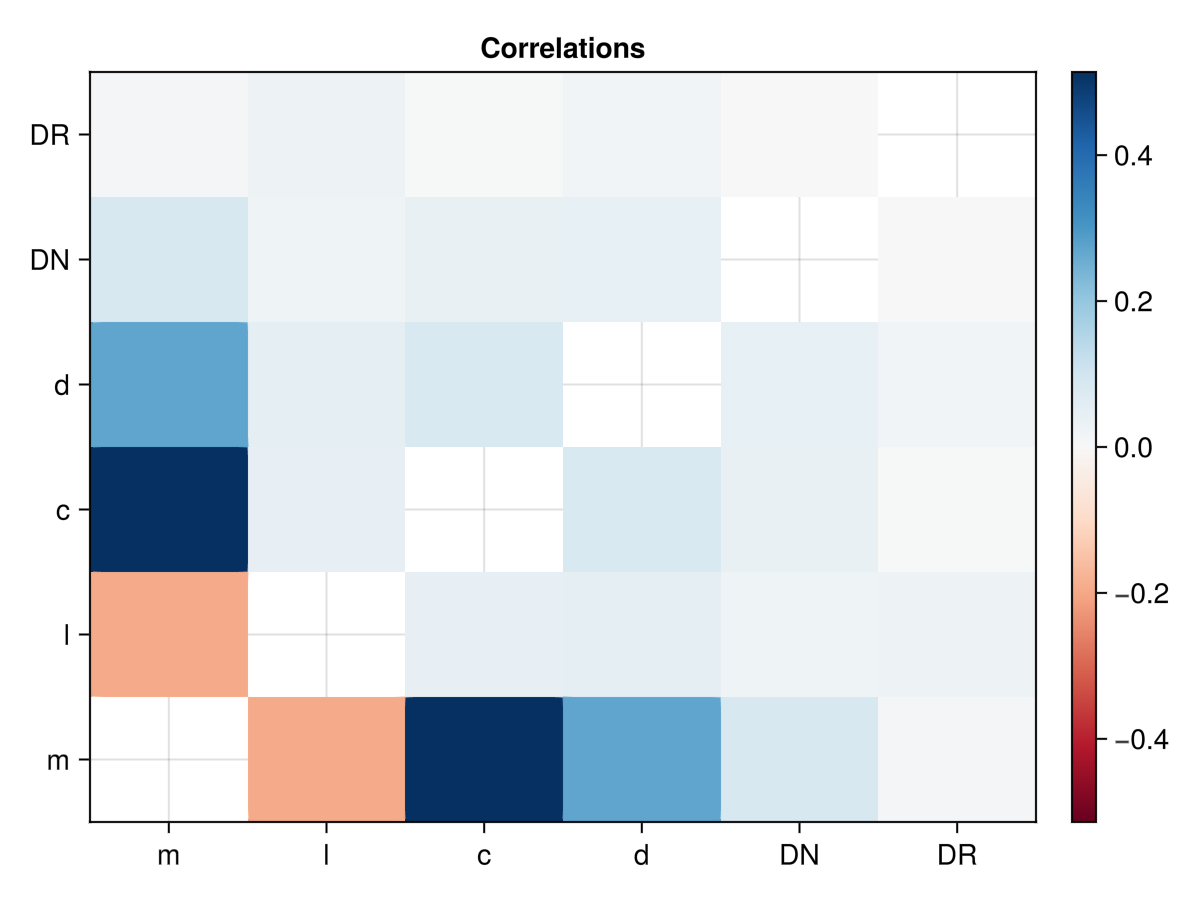

In [100]:
fap = plot_df_correlations(df, Not(:K,:DG,:numss,:nummodes))
# display(GLMakie.Screen(), fap.figure)
fap

### All basic 1d freqs

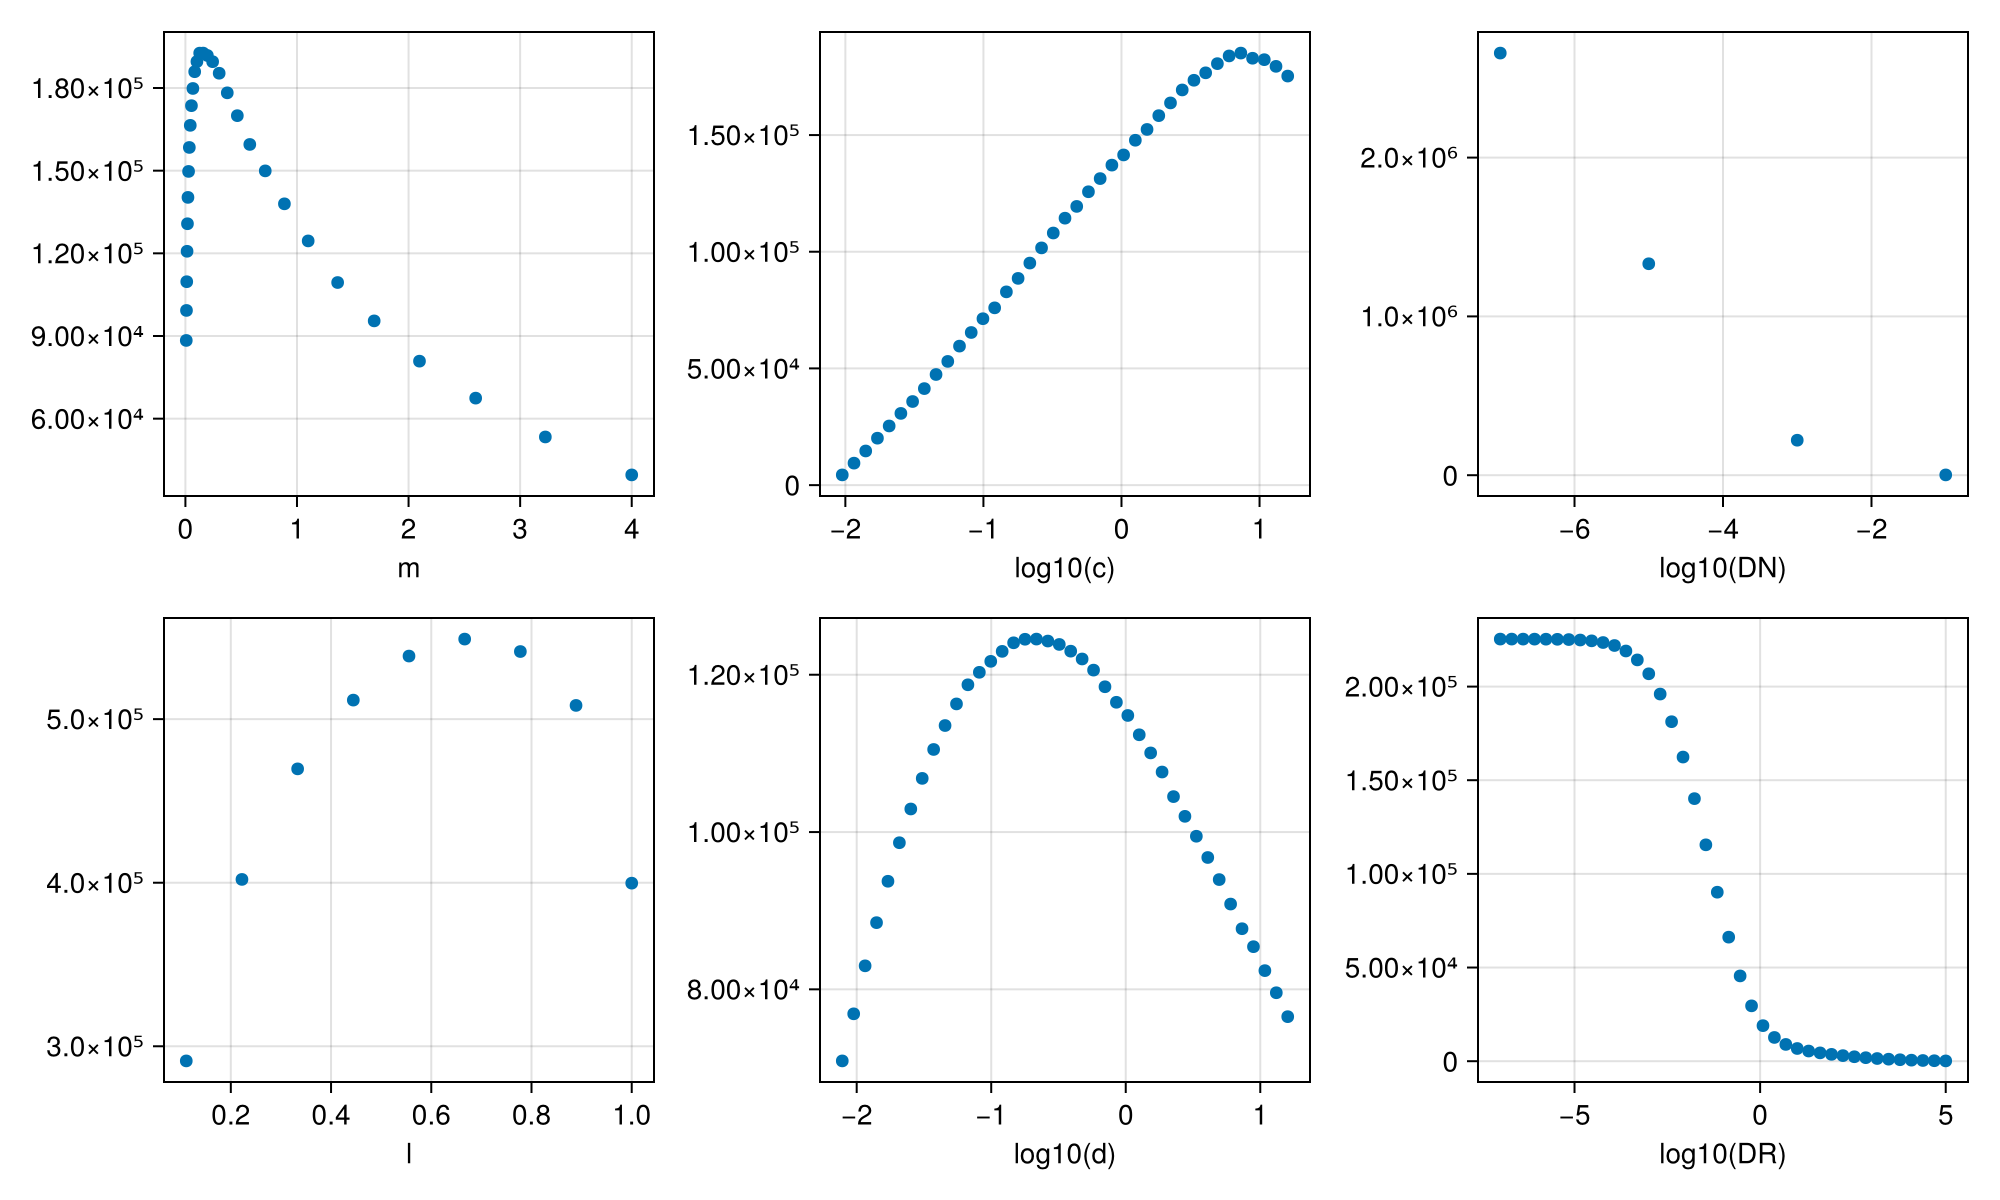

In [107]:
f = Figure(size=(1000, 600))
ax_m = Axis(f[1, 1])
plot_namedvector_numeric!(ax_m, freqtable(df, :m))
ax_l = Axis(f[2, 1])
plot_namedvector_numeric!(ax_l, freqtable(df, :l))
ax_c = Axis(f[1, 2])
plot_namedvector_numeric!(ax_c, freqtable(df, :c); logx=10)
ax_d = Axis(f[2, 2])
plot_namedvector_numeric!(ax_d, freqtable(df, :d); logx=10)
ax_DN = Axis(f[1, 3])
plot_namedvector_numeric!(ax_DN, freqtable(df, :DN); logx=10)
ax_DR = Axis(f[2, 3])
plot_namedvector_numeric!(ax_DR, freqtable(df, :DR); logx=10)

# save(datadir("im.png"), f)
f

### One dim freqs

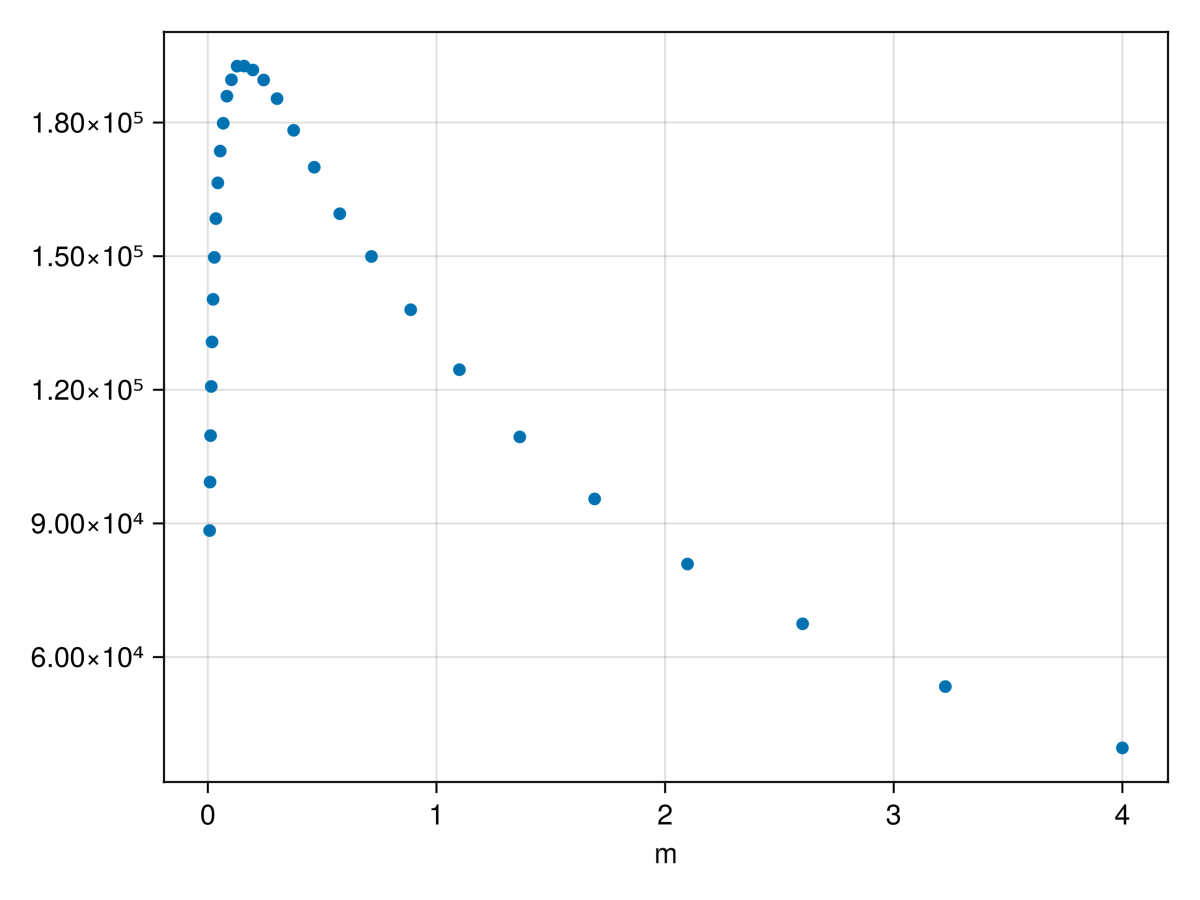

In [71]:
xx = freqtable(df, :m)
plot_namedvector_numeric(xx; logx=nothing)

### Two dim freqs

In [199]:
using DataFramesMeta

In [238]:
aa = @subset df isapprox.(:l, 1.) isapprox.(:m, 0.15; atol=0.01);
nrow(aa)

18523

In [243]:
sort(unique(df.c));

In [316]:
aa = df[
    isapprox.(df.l, 1.) .&&
    isapprox.(df.m, 0.15; atol=0.01) .&&
    # isapprox.(df.c, 10.; atol=1.) .&&
    # isapprox.(df.d, 10.; atol=1.) .&&
    isapprox.(df.DN, 1e-7; atol=1e-6) .&&
    isapprox.(df.DR, 0.017; atol=0.001)
    ,:];
nrow(aa)
# unique(aa.c)

403

sdf.l[1] = 1.0


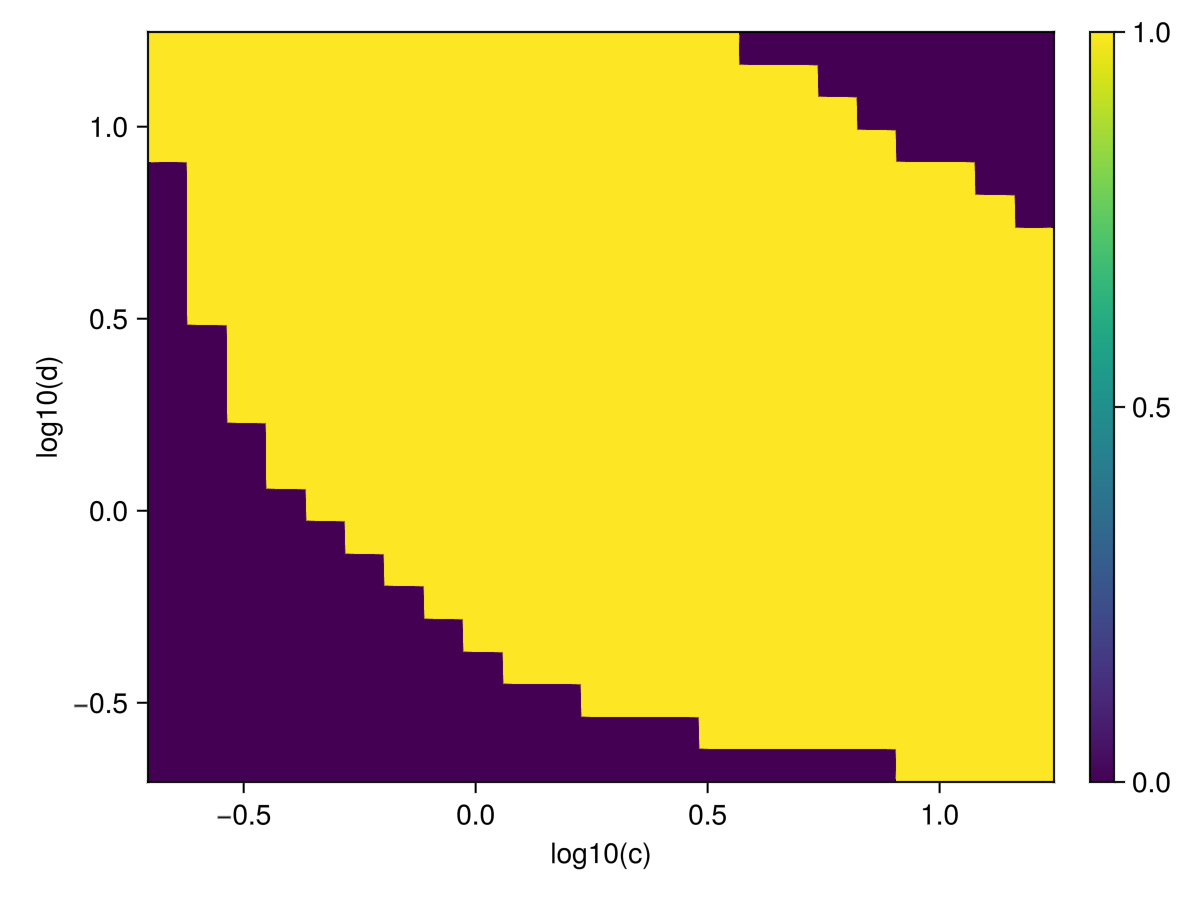

In [320]:
# sdf = df[df.l .== 1., :]
# sdf = lgb[2]
sdf = aa
@show sdf.l[1]
xx = freqtable(sdf, :c, :d);
plot_namedmatrix_numeric(xx; logx=10, logy=10)

## "Marginalized" heatmaps

## Clustering?

In [107]:
using Clustering

In [246]:
ci = transpose(Matrix(df[!,Not(:numss,:nummodes)]));
size(ci)

(8, 4211302)

In [218]:
ci = ci[:,rand(1:size(ci)[2], 10000)]
size(ci)

(8, 10000)

In [298]:
xx = kmeans(ci, 6)
q = clustering_quality(ci, xx; quality_index=:calinski_harabasz)
# q = clustering_quality(ci, xx; quality_index=:xie_beni)
# q = clustering_quality(ci, xx; quality_index=:davis_bouldin)
# q = clustering_quality(ci, xx; quality_index=:dunn)
# q = clustering_quality(ci, xx; quality_index=:silhouettes)

q

2.4639289316588315e8

In [302]:
Ns = 2:10
qs = []

reps = 10
for N in Ns
    avg_q = 0.
    for _ in 1:reps
        xx = kmeans(ci, N)
        q = clustering_quality(ci, xx; quality_index=:calinski_harabasz)
        avg_q += q
    end
    push!(qs, q / reps)
end
qs

9-element Vector{Any}:
 1.360286296185331e6
 1.3194979343693466e6
 2.7763587582013113e6
 1.0188979376117956e7
 1.5458859638783824e7
 3.9534891675487064e7
 1.0158976083483829e8
 2.3993036170983058e8
 2.4247337773010546e8

In [100]:
N = 10
subdf = df[rand(1:nrow(df), N),Not(:numss,:nummodes)];
xx = Matrix(subdf)
dci = [sqrt(sum((x .- y) .^ 2)) for x in eachrow(xx), y in eachrow(xx)]
@show size(dci)

size(dci) = (10, 10)


(10, 10)

In [105]:
xx = affinityprop(dci)

AffinityPropResult([3, 9], [1, 2, 1, 1, 1, 2, 1, 1, 2, 1], [7, 3], 200, false)

In [106]:
nclusters(xx)

2

# Additional numerics for a single system

In [145]:
mmpf = df_row_to_mmp(get_random_row(df));

In [146]:
# mmpf = MinimalModelParamsSpace(0.1, 0., 10., 0.01, 0.01, 1e-5, 0.01584893192461114, 0.00039810717055349735);
# mmpf = MinimalModelParamsSpace(fi_to_fparams(fi_to_run)...)
mmicrm_params = mmp_to_mmicrm(mmpf);
mmpf

MinimalModelParamsSpace{Float64}(2.097928510646069, 0.4444444444444444, 1.0, 7.319752519067485, 0.020764405976160197, 1.0e-7, 1.0, 3.455107294592218e-6)

In [127]:
xx = da_get_diff_lengthscales_simple(mmicrm_params, get_Ds(mmpf), [1., 1., 1.]; include_infs=false)
(2*pi) ./ xx

(29902.698267657208, 2.248148770809361)

In [128]:
xx = analyze_single_mmps_Kpoly(mmpf; include_extinct=false)
println((xx[1], xx[2]))
print("sss: ")
show(xx[3])
println()
print("kroots fe ss: ")
show(xx[4])
println()
print("nummodes fe ss fe segment: ")
show(xx[5])

(1, 1)
sss: [[6.724823051496198, 0.061608706116546896, 0.0774545984004266]]
kroots fe ss: [[15.58055380416481, 71.309442849275]]
nummodes fe ss fe segment: [[0, 1, 0]]

In [129]:
# choose a ss for lisntab etc.
nssol = xx[3][1]

3-element Vector{Float64}:
 6.724823051496198
 0.061608706116546896
 0.0774545984004266

In [131]:
xx = analyze_single_mmps_kscan(mmpf, LinRange(0., 100., 1000))

(1, 1, [[6.724823051496198, 0.061608706116546896, 0.0774545984004266]], Bool[0])

## Numerics

#### No space solver

3-element Vector{Float64}:
 0.12873950300127388
 0.5148715256224812
 0.21503770863012853

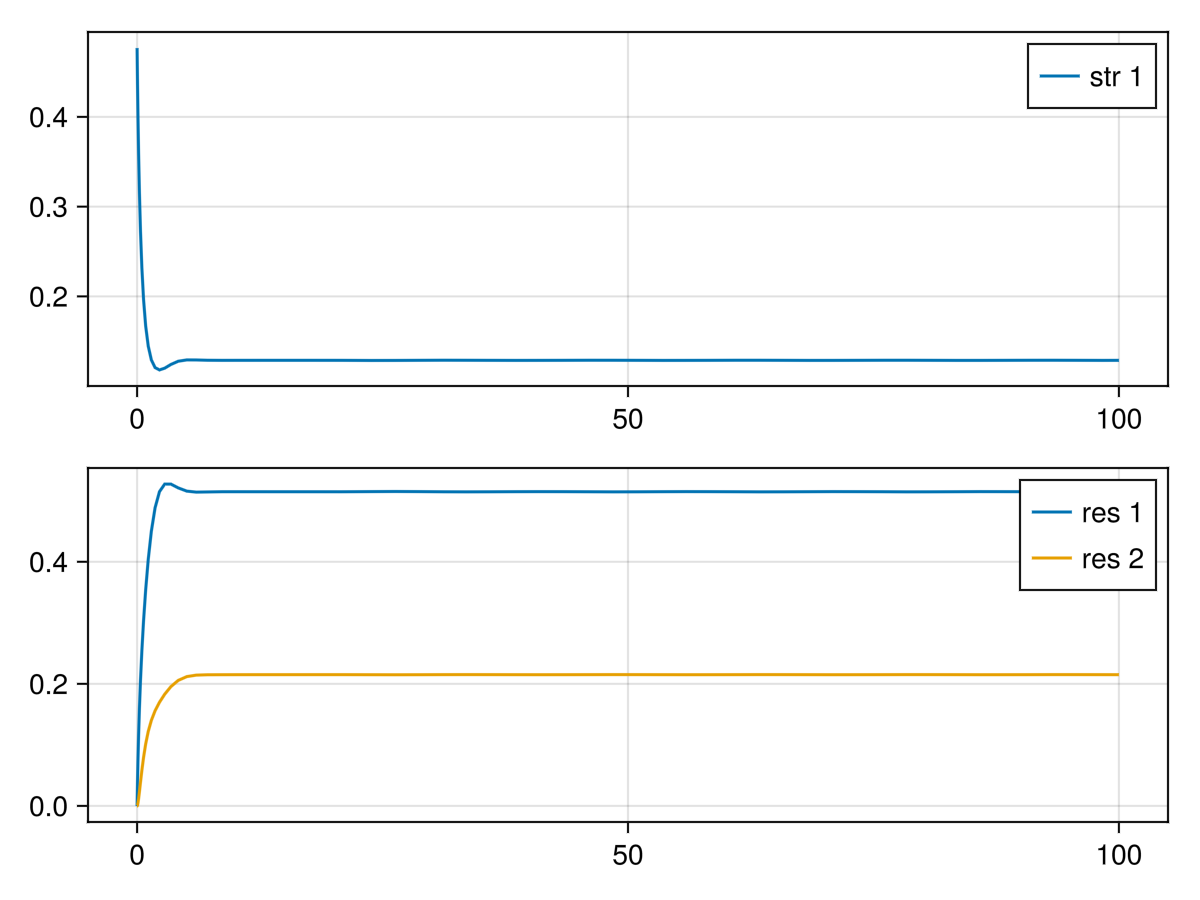

In [150]:
u0 = make_mmicrmu0_smart(mmicrm_params; u0=:maxNs)
# u0 = [10., 0., 0.]
# u0 = nssol .* (1 .+ 10. .* (rand(3) .- 0.5))
nsp = ODEProblem(mmicrmfunc!, u0, (0, 100), mmicrm_params)

check_mmicrmparams(nsp.p)
s = solve(nsp)
display(s.u[end])
plot_mmicrm_sol(s)

#### Linstab

mrl = 0.0009422859189227584


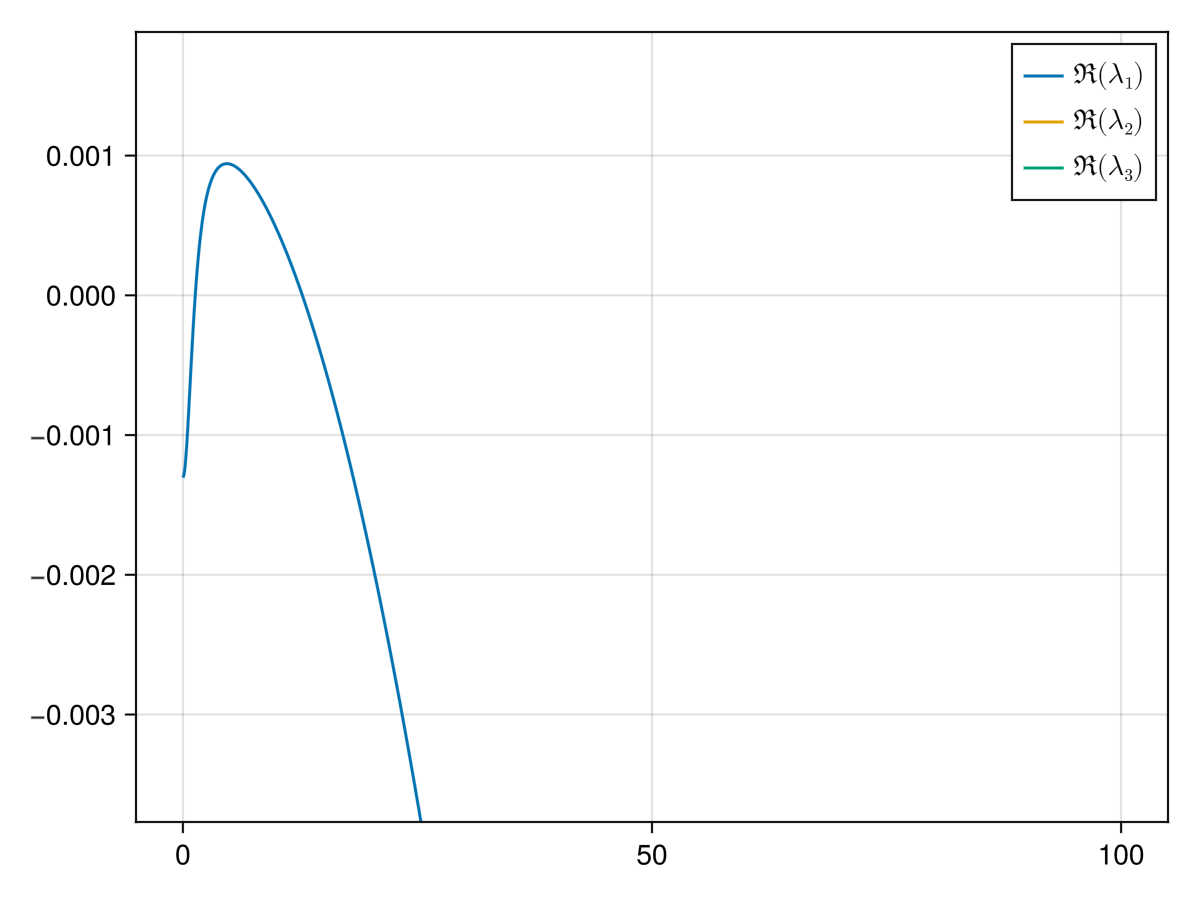

In [273]:
ks = LinRange(0.0, 100, 1000)
Ds = collect(get_Ds(mmpf))

lambdas = do_linstab_for_ks(ks, mmicrm_params, Ds, nssol);
mrl = maximum(real(lambdas))
@show mrl
faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-4*abs(mrl), 2*abs(mrl)))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [46]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(mmicrm_params, nssol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.9987892464334153
  3.0666706787900966e-5
 -0.04919390479036403

### 1D PDE sim

In [146]:
ssize = (20000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform_prop(get_Ns(mmicrm_params)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.001, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1e6, mmicrm_params, get_Ds(mmpf), space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 20000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.001]))

In [147]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  8.191191 seconds (856.75 k allocations: 5.342 GiB, 14.93% gc time)
Success
nf is 718
solution has 163 saved states
max resid is 1.35507e-06


┌ Warning: reaching negative values, minimum is -4.41538e-07
└ @ SSMCMain.ModifiedMiCRM.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/SpaceMMiCRM/smmicrm_util.jl:10


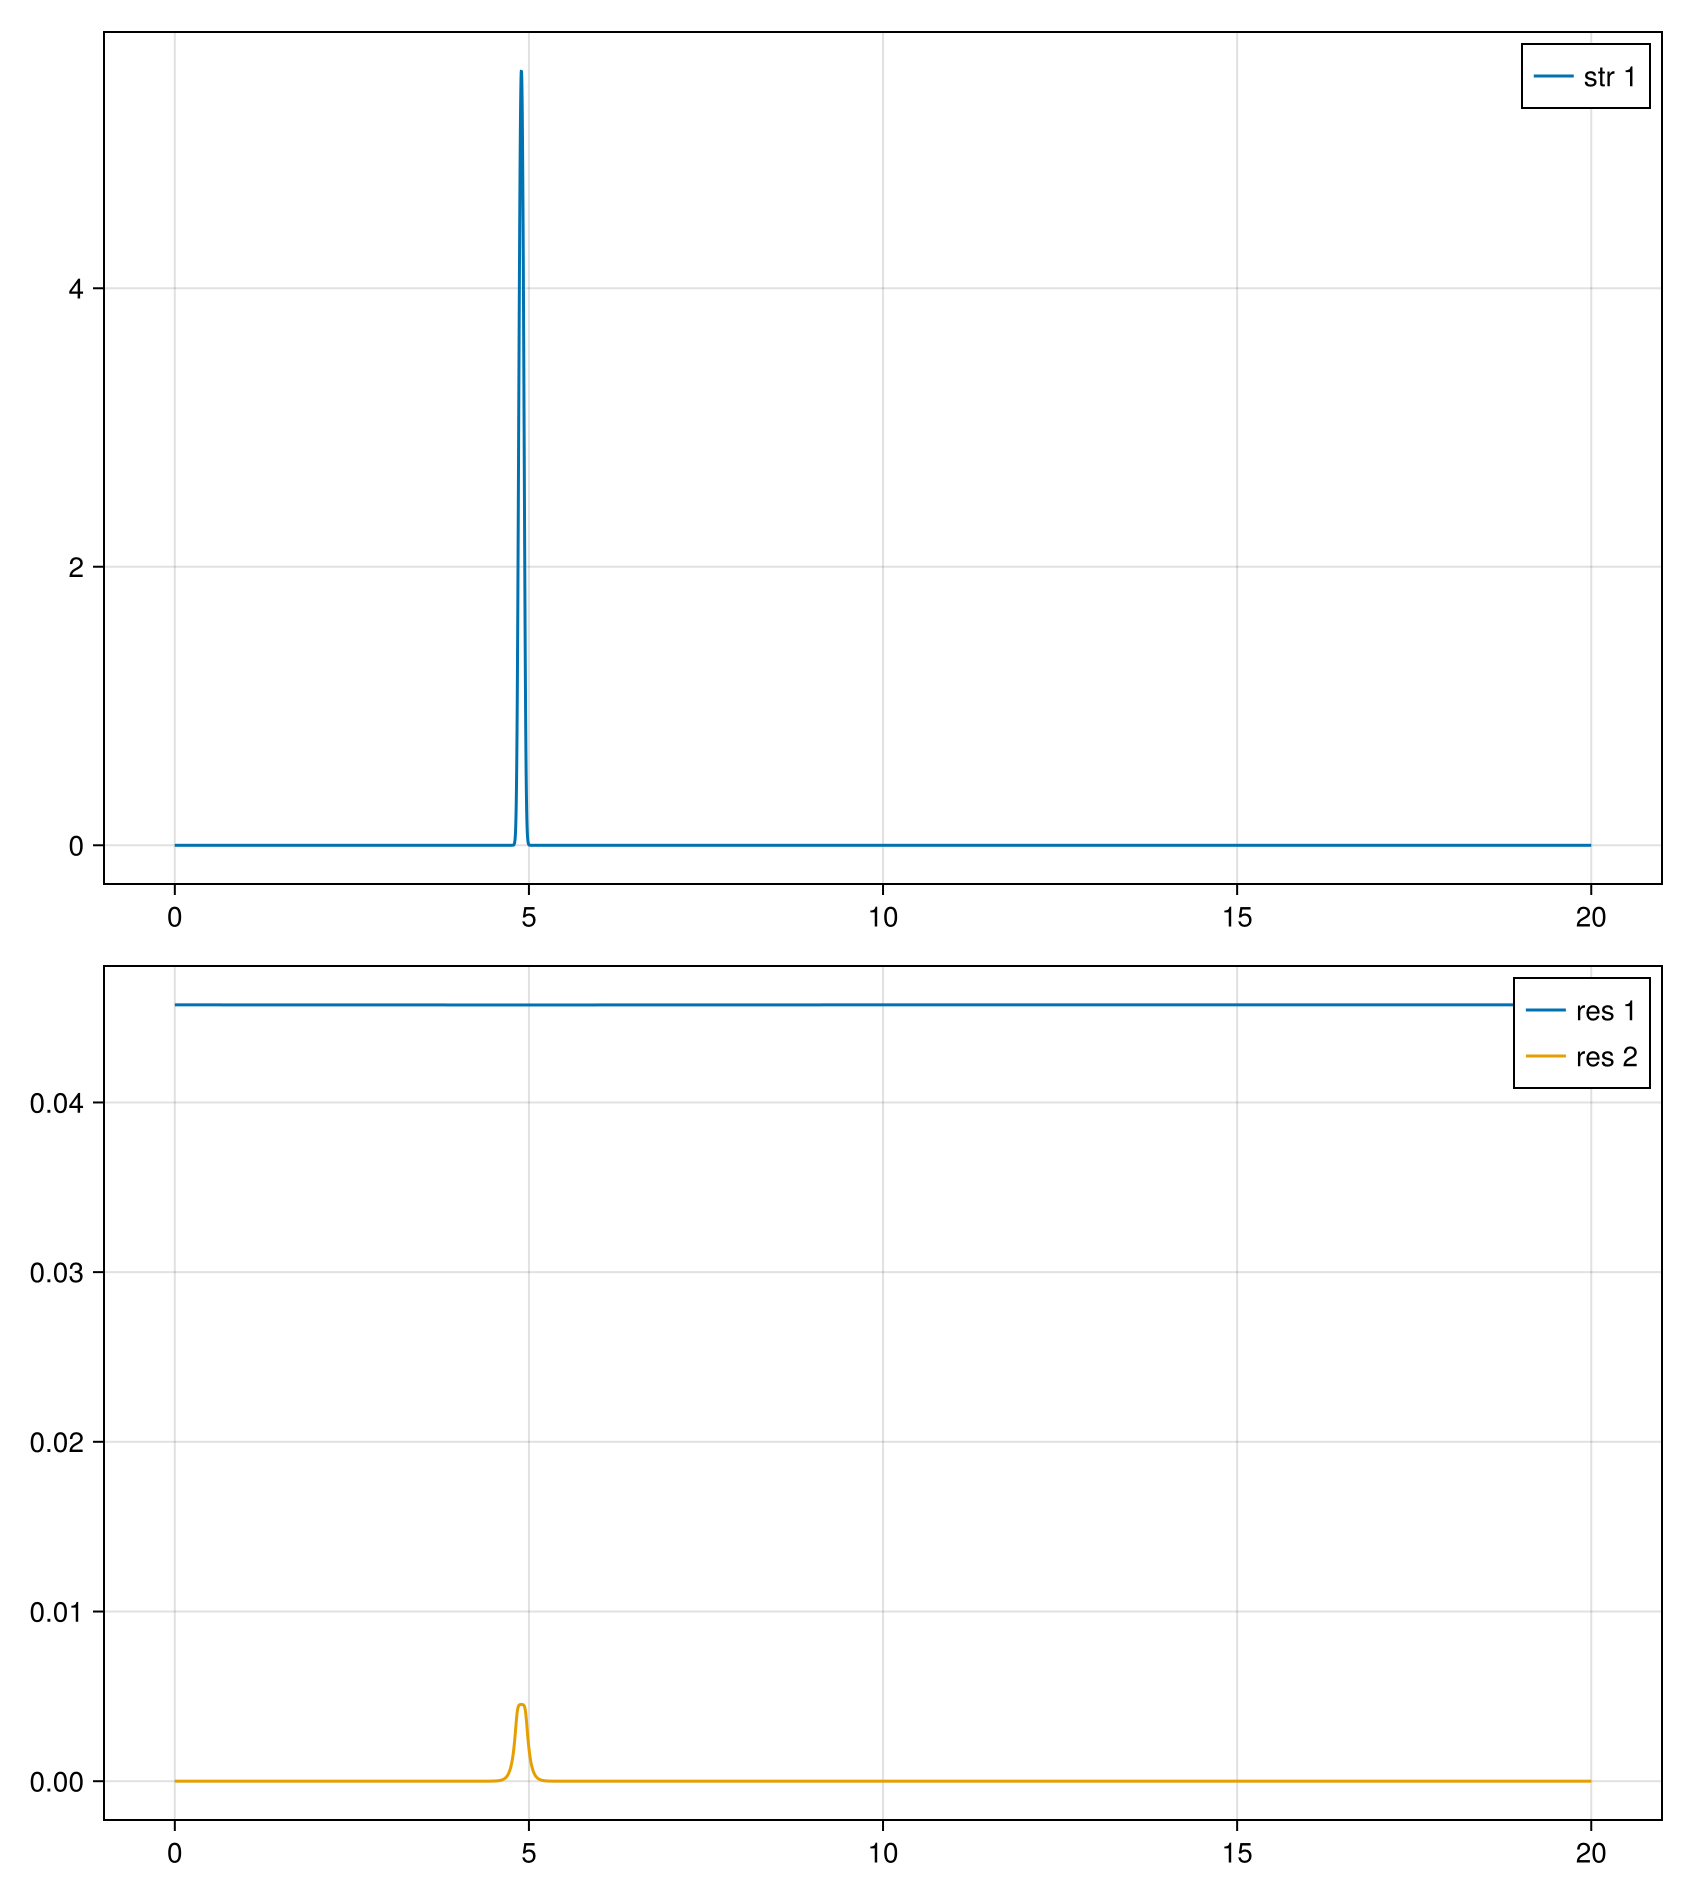

In [150]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))
display(GLMakie.Screen(), faa.figure)
faa

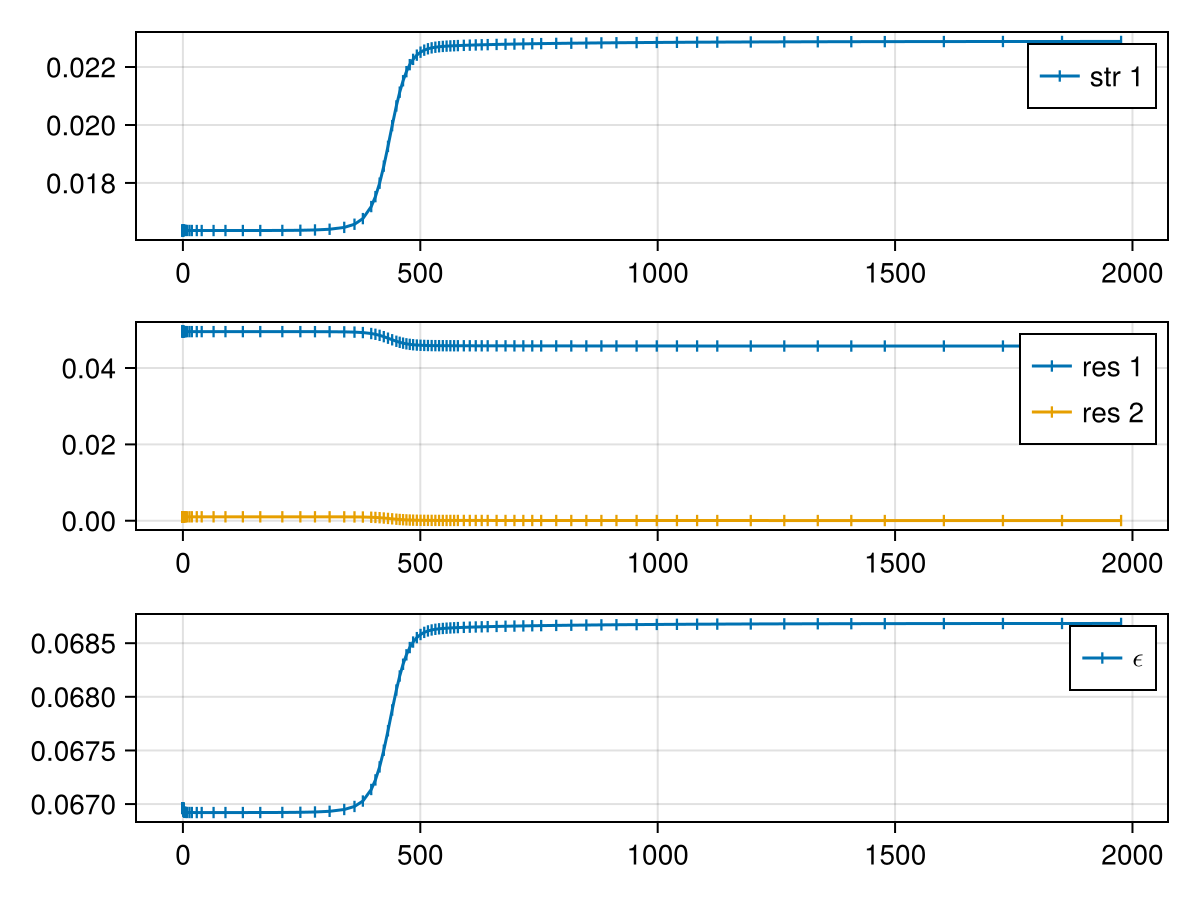

In [149]:
f = plot_smmicrm_sol_avgs(sps, 1:(length(sps.t)-10); plote=true)
# display(GLMakie.Screen(), f)

# Extras

### Testing scanning k stability analysis

In [311]:
N = 10000
ks = LinRange(0., 100., 10000)
for _ in 1:N
    dfrow = get_random_row(df)
    mmpf = df_row_to_mmp(dfrow)
    xx = analyze_single_mmps_kscan(mmpf, ks)
    if xx[2] != dfrow.nummodes
        @show xx# dfrow.numss dfrow.nummodes
        @show analyze_single_mmps_Kpoly(mmpf)
    end
end

xx = (1, 0, [[6.545830699535399, 2.270846502323003, 3.5458306995354]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[6.545830699535399, 2.270846502323003, 3.5458306995354]], [[931.9578870634543, 1729.2162096971135]], [[0, 1, 0]])
xx = (1, 0, [[9.692781856144013, 5.473462242551887, 4.537250088781851]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[9.692781856144013, 5.473462242551887, 4.537250088781851]], [[197.68498245367596, 537.0239594988301]], [[0, 1, 0]])
xx = (1, 0, [[6.096440684786595, 0.11729438402027532, 1.2718090912490065]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[6.096440684786595, 0.11729438402027532, 1.2718090912490065]], [[129.39270782668513, 480.2555950791281]], [[0, 1, 0]])
xx = (1, 0, [[3.032088680599828, 0.1179058233838167, 1.8187325263624383]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[3.032088680599828, 0.1179058233838167, 1.8187325263624383]], [[489.0872723237346, 1165.965811445184]], [[0, 1, 0]])
xx = (1, 0, [[36.730217501626626, 0

┌ Warning: error in renderloop
│   exception =
│    InterruptException:
│    Stacktrace:
│      [1] poptask(W::Base.IntrusiveLinkedListSynchronized{Task})
│        @ Base ./task.jl:999
│      [2] wait()
│        @ Base ./task.jl:1008
│      [3] wait(c::Base.GenericCondition{SpinLock}; first::Bool)
│        @ Base ./condition.jl:130
│      [4] wait
│        @ ./condition.jl:125 [inlined]
│      [5] _trywait(t::Timer)
│        @ Base ./asyncevent.jl:142
│      [6] wait
│        @ ./asyncevent.jl:159 [inlined]
│      [7] sleep(sec::Float64)
│        @ Base ./asyncevent.jl:265
│      [8] sleep(timer::Makie.BudgetedTimer)
│        @ Makie ~/.julia/packages/Makie/ux0Te/src/utilities/timing.jl:121
│      [9] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
│        @ GLMakie ~/.julia/packages/GLMakie/87u59/src/screen.jl:1044
│     [10] renderloop(screen::GLMakie.Screen{GLFW.Window})
│        @ GLMakie ~/.julia/packages/GLMakie/87u59/src/screen.jl:1061
│     [11] (::GLMakie.var"#79#80